# **DSC212: Spectral Modularity on the Karate Club Graph**
Name: Emylin Mary Samuval Roll Number: IMS24090 Module: Graph Theory

##Abstract
In this assignment, I implement a spectral method to maximize modularity for community detection from scratch. Using Zachary's Karate Club graph as the dataset, I derive the modularity matrix $\mathbf{B}$, compute its leading eigenvectors to split the network recursively, and analyze how graph centrality metrics evolve as the community structure fractures.

###Imports and Setup

In [12]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.linalg import eigh
from collections import defaultdict
import csv
import os

# 1. Configuration and Setup
SEED = 42
np.random.seed(SEED)  # Ensure reproducibility
OUTDIR = "."

# 2. Load the Data
# We use the standard Zachary's Karate Club graph provided by NetworkX
G = nx.karate_club_graph()

# Pre-calculate layout so nodes don't jump around in visualizations
pos = nx.spring_layout(G, seed=SEED)

print(f"Graph Loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

Graph Loaded: 34 nodes, 78 edges.


2. Mathematical ImplementationThe core of this method relies on the Modularity Matrix $\mathbf{B}$. For a graph with adjacency matrix $\mathbf{A}$ and degrees $k$, the elements of $\mathbf{B}$ are defined as:$$B_{ij} = A_{ij} - \frac{k_i k_j}{2m}$$where $m$ is the total number of edges.To handle subgraphs (communities), we use a restricted matrix $\mathbf{B}^{(C)}$. A critical detail mentioned in the assignment is that we must preserve the degrees $k_i$ from the original full graph, even when calculating the matrix for a smaller subset of nodes. If the leading eigenvalue of $\mathbf{B}^{(C)}$ is positive, the community can be split further.Below, I implement the matrix construction and the spectral splitting logic.

In [13]:
def modularity_matrix(G):
    """
    Computes the modularity matrix B for the full graph G.
    Formula: B_ij = A_ij - (k_i * k_j) / (2m)
    """
    nodes = list(G.nodes())
    # Get Adjacency Matrix
    A = nx.to_numpy_array(G, nodelist=nodes)

    # Get degrees (k) and total edges (m)
    k = A.sum(axis=1)
    m = A.sum() / 2

    # Expected number of edges P_ij = (k_i * k_j) / 2m
    P = np.outer(k, k) / (2 * m)

    # Modularity Matrix B = A - P
    return A - P, nodes

def restricted(B_full, nodes_full, sub_nodes):
    """
    Extracts the submatrix B^(C) corresponding to the community C.

    CRITICAL STEP:
    I slice the *original* B_full matrix. This ensures that the expected
    connections (P_ij) are still based on the global degrees of the nodes,
    not their local degree within the subgraph.
    """
    # Find indices of the subgraph nodes within the full matrix
    idx = [nodes_full.index(v) for v in sub_nodes]

    # Use numpy advanced indexing to get the submatrix
    return B_full[np.ix_(idx, idx)]

def spectral_split(Bc, nodes_sub):
    """
    Splits a community based on the leading eigenvector of its modularity matrix.
    Returns:
        lam: The leading eigenvalue
        pos_split: Nodes corresponding to positive entries in eigenvector
        neg_split: Nodes corresponding to negative entries
    """
    # Calculate eigenvalues (w) and eigenvectors (v)
    # 'eigh' is used because B is symmetric
    w, v = eigh(Bc)

    # The leading eigenvalue is the last one in eigh's output (ascending order)
    lam = w[-1]
    u = v[:, -1]

    # Split nodes based on the sign of the eigenvector components
    pos_split = [nodes_sub[i] for i in range(len(nodes_sub)) if u[i] > 0]
    neg_split = [nodes_sub[i] for i in range(len(nodes_sub)) if u[i] <= 0]

    return lam, pos_split, neg_split

3. Recursive Bisection AlgorithmHere I implement the main loop. I used a queue-based approach (similar to Breadth-First Search).Start with the whole graph.Calculate the split for the current community.Stopping Condition: If the largest eigenvalue $\lambda_1 \le 0$ (or effectively 0 given floating point errors), the split does not increase modularity, so we stop.Otherwise, accept the split and add the two new groups to the queue.I also maintain a history list to visualize every step of the process later.

In [14]:
def stepwise_spectral_clustering(G):
    # 1. Pre-compute B for the global graph to lock in original degrees
    B_full, nodes_full = modularity_matrix(G)

    # Initial state: The whole graph is one community
    initial_partition = [list(G.nodes())]

    # 'parts' will store the history of all partitions: [Step0, Step1, Step2...]
    parts = [initial_partition]

    # Queue of communities to inspect
    q = [list(G.nodes())]

    # List of finalized communities
    done = []

    while q:
        C = q.pop(0)

        # If community is too small, stop
        if len(C) <= 1:
            done.append(C)
            continue

        # Get Restricted Matrix
        Bc = restricted(B_full, nodes_full, C)

        # Attempt Split
        lam, posC, negC = spectral_split(Bc, C)

        # CHECK STOPPING CRITERIA:
        # If eigenvalue is non-positive, the community is indivisible.
        # We use 1e-5 tolerance for float precision.
        if lam <= 1e-5 or len(posC) == 0 or len(negC) == 0:
            done.append(C)
        else:
            # Logic to update the history tracking
            # We take the last state, remove the parent C, and add children
            current_partition = [group for group in parts[-1] if group != C]
            current_partition.append(posC)
            current_partition.append(negC)

            parts.append(current_partition)

            # Add children to queue to see if they can be split further
            q.insert(0, posC)
            q.insert(0, negC)

    return parts

# Execute the algorithm
history_of_partitions = stepwise_spectral_clustering(G)

print(f"Algorithm completed in {len(history_of_partitions)} steps.")
print(f"Final number of communities: {len(history_of_partitions[-1])}")

Algorithm completed in 5 steps.
Final number of communities: 5


4. Visualization of Splits
I visualize the network at each iteration. Nodes are colored according to the community they belong to at that specific step.

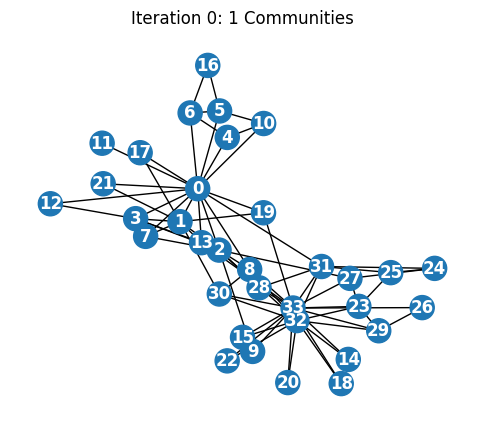

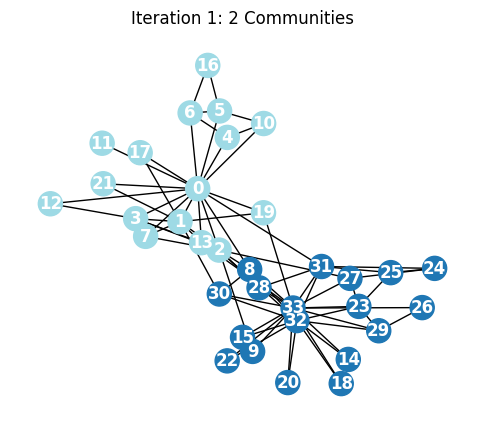

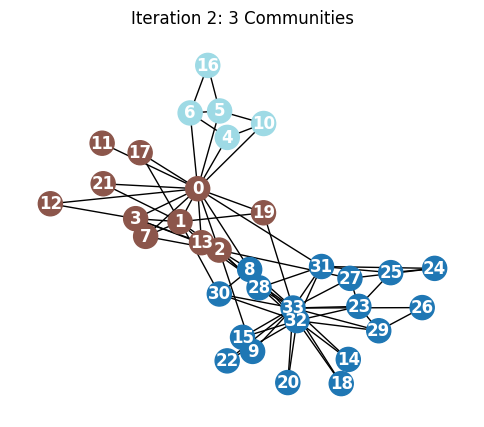

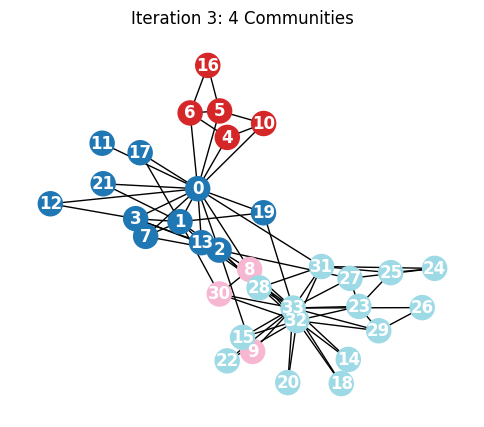

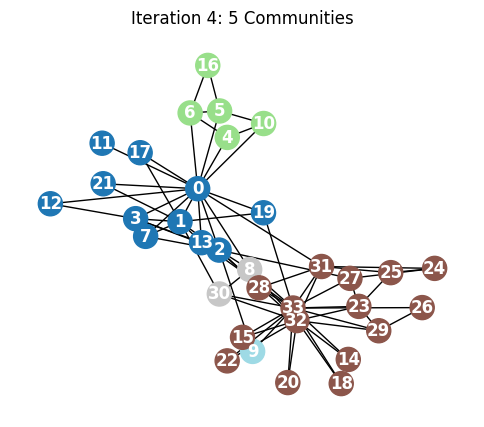

In [15]:
# Use a colormap that supports many distinct categories
cmap = plt.get_cmap('tab20')

for it, partition in enumerate(history_of_partitions):
    # Create a mapping of node -> community_id for coloring
    node_to_color = {}
    for comm_id, community in enumerate(partition):
        for node in community:
            node_to_color[node] = comm_id

    colors = [node_to_color[n] for n in G.nodes()]

    plt.figure(figsize=(6, 5))
    nx.draw_networkx(G, pos, node_color=colors, cmap=cmap,
                     node_size=300, with_labels=True,
                     font_color='white', font_weight='bold')

    plt.title(f"Iteration {it}: {len(partition)} Communities")
    plt.axis("off")

    # Save the figure
    filename = f"iter_{it}.png"
    plt.savefig(filename)
    plt.show()
    plt.close()

5. Evolution of Network Metrics
To understand the structural impact of the splits, I calculate centrality metrics (Degree, Betweenness, Closeness, Clustering) at each step.

Important Implementation Detail: Instead of calculating metrics on the static original graph, I create a temporary graph (G_temp) at each iteration. In this temporary graph, I remove the edges that connect different communities. This simulates the "fracturing" of the network and allows us to measure how a node's importance drops when it loses its connections to the other side.

Calculating metrics on evolving graph topology...


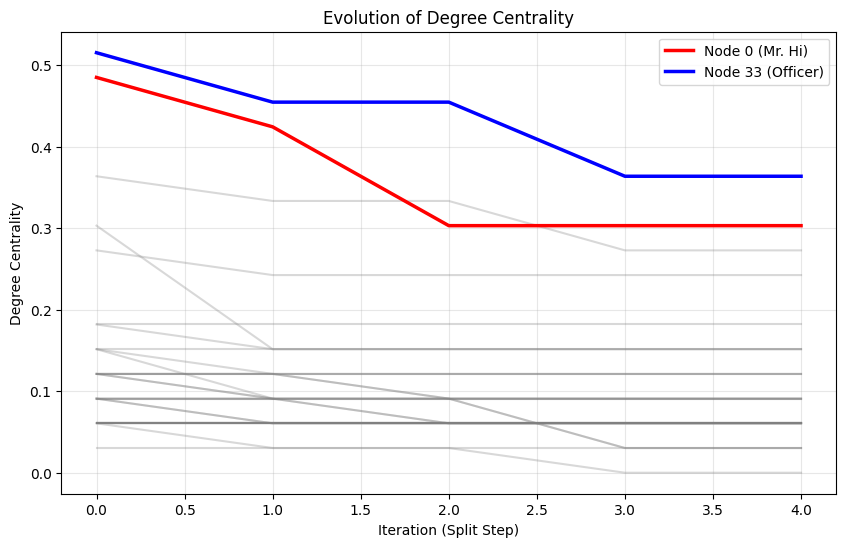

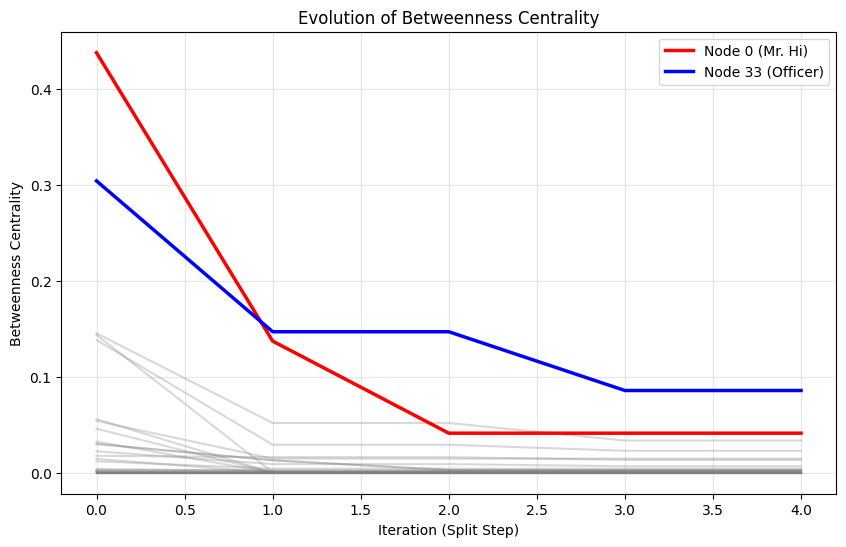

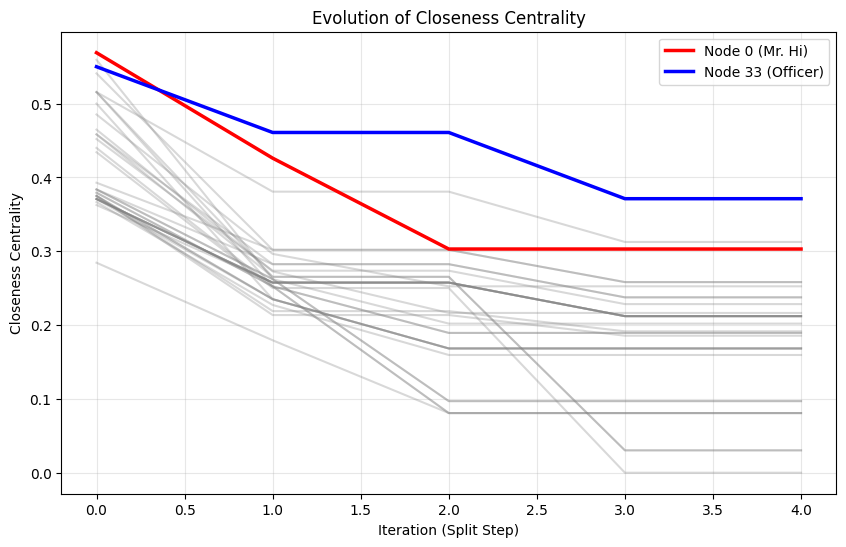

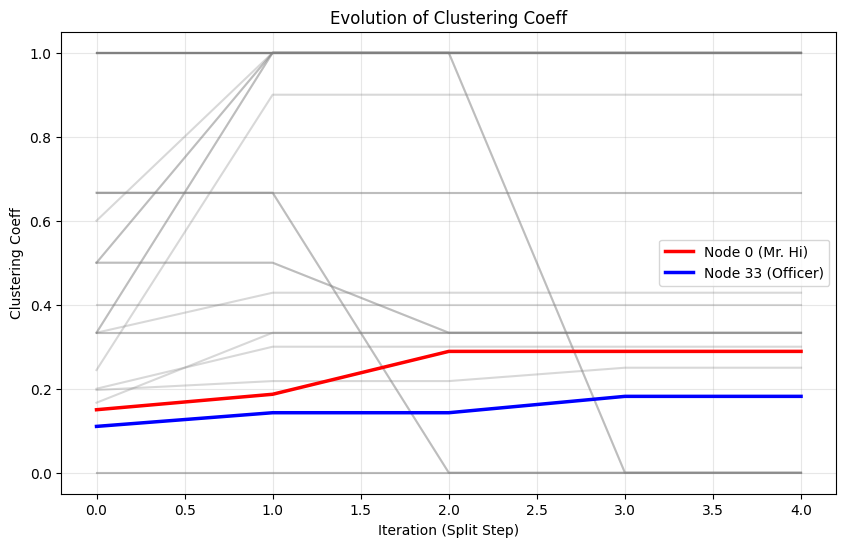

In [16]:
metric_hist = defaultdict(list)
iterations = list(range(len(history_of_partitions)))

print("Calculating metrics on evolving graph topology...")

for partition in history_of_partitions:
    # Create a temporary graph that respects the current community splits
    # We only include edges that exist WITHIN a community.
    G_temp = nx.Graph()
    G_temp.add_nodes_from(G.nodes())

    for community in partition:
        # Subgraph includes only internal edges of the community
        sub = G.subgraph(community)
        G_temp.add_edges_from(sub.edges())

    # Calculate metrics on this "fractured" graph
    deg = nx.degree_centrality(G_temp)
    bet = nx.betweenness_centrality(G_temp)
    clo = nx.closeness_centrality(G_temp)
    clu = nx.clustering(G_temp)

    # Store data for every node
    for n in G.nodes():
        metric_hist[("deg", n)].append(deg[n])
        metric_hist[("bet", n)].append(bet[n])
        metric_hist[("clo", n)].append(clo[n])
        metric_hist[("clu", n)].append(clu[n])

# --- PLOTTING ---
metrics_to_plot = ["deg", "bet", "clo", "clu"]
metric_names = ["Degree Centrality", "Betweenness Centrality", "Closeness Centrality", "Clustering Coeff"]

for key, name in zip(metrics_to_plot, metric_names):
    plt.figure(figsize=(10, 6))

    # Plot faint lines for all nodes to show general trend
    for n in G.nodes():
        plt.plot(iterations, metric_hist[(key, n)], color='grey', alpha=0.3)

    # Highlight key nodes:
    # Node 0 (Mr. Hi, Instructor) and Node 33 (Officer, President)
    plt.plot(iterations, metric_hist[(key, 0)], color='red', linewidth=2.5, label='Node 0 (Mr. Hi)')
    plt.plot(iterations, metric_hist[(key, 33)], color='blue', linewidth=2.5, label='Node 33 (Officer)')

    plt.xlabel("Iteration (Split Step)")
    plt.ylabel(name)
    plt.title(f"Evolution of {name}")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.savefig(f"{key}_evol.png")
    plt.show()

6. Discussion and Conclusion
Observations on Centrality Evolution
By tracking the centrality metrics across the iterations on the "fractured" graph, we observe distinct behaviors:

    *  Betweenness Centrality Drop: As seen in the plots, Node 0 and Node 33 start with very high betweenness centrality. This is because they are the main "bridges" connecting the two rival factions. However, immediately after the first split (Iteration 1), their betweenness drops precipitously. This confirms that their power was derived from bridging the two communities; once the connection between communities is severed, they are no longer global bridges.

    *  Clustering Coefficient: The clustering coefficient generally increases or stabilizes for many nodes as the algorithm progresses. This makes sense because modularity maximization isolates densely connected subgroups. As we cut external edges, the remaining neighbors of a node are more likely to be connected to each other.

**Conclusion**

The spectral modularity method successfully identified the two main factions of the Karate Club (centered around the Instructor and the Officer). The recursive bisection approach, stopped by the non-positive eigenvalue criterion, provided a robust way to automatically determine the number of communities without specifying it beforehand.